In [2827]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn import metrics
from sklearn.feature_selection import mutual_info_regression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

### START MSE = 0.01034

In [2829]:
data = pd.read_csv("train.csv")
data.sample(10)

,Unnamed: 0,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
348,3373,information_source,2221425.0,0.0,0,147096,71648,14483,4.378045,0.138801,2021-12-09 12:33:30.508811760
3051,9321,information_source,801861.0,160774.0,0,27568,11904,3451,0.486020,-0.039423,2024-07-10 22:21:06.471566538
4962,2445,ecom,3070773.0,1497170.0,718775,35946,0,-,4.401136,0.482673,2021-04-21 13:13:16.304080704
3703,6739,news,1365352.0,144960.0,0,96317,0,1720,-1.000000,0.231475,2022-09-18 22:28:34.704244016
7183,7792,information_source,1613649.0,22465.0,0,94255,4585,2341,5.771893,0.090248,2023-10-10 03:35:39.575562872
3883,4278,information_source,2287280.0,478559.0,0,0,0,451,5.740680,0.065440,2024-03-11 14:47:09.178772080
6786,9079,news,291068.0,5032.0,0,7452,14005,2949,3.405373,-0.126041,2024-08-26 16:55:22.754062475
6862,1140,ecom,3798016.0,0.0,0,37136,0,1360,6.608831,0.029576,2023-09-18 01:06:47.121429096
3326,6912,ecom,142087.0,9624.0,97114,5893,592,-,-1.000000,0.473410,2024-04-03 22:07:07.849062948
835,5126,news,1900743.0,101789.0,0,192002,0,2237,7.636252,0.170215,2022-09-10 04:34:46.384347384


In [2830]:
def cleaning_data_reg_date(data: pd.core.frame.DataFrame)->pd.core.frame.DataFrame:
    data["date_of_registration"] = pd.to_datetime(data["date_of_registration"])
    data["register_coef"] = (pd.Timestamp("2024-10-15")-data["date_of_registration"])/pd.Timedelta(days=365)
    data = data.drop(columns="date_of_registration")

    return data

In [2831]:
data_clean = cleaning_data_reg_date(data)
data_clean = data_clean.drop(columns="Unnamed: 0")
data_clean 

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,register_coef
0,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,4.485836
1,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,0.238375
2,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,0.255639
3,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,0.093438
4,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,0.387772
...,...,...,...,...,...,...,...,...,...,...
7995,information_source,1468601.0,474524.0,0,61307,83928,16841,4.191481,0.017470,1.321027
7996,information_source,93172.0,6418.0,0,3418,705,0,3.745192,-0.019069,0.231877
7997,information_source,82916.0,0.0,0,4302,1718,1007,5.837475,-0.061523,0.328112
7998,social,823896.0,105666.0,0,0,2892,267,11.994037,0.131620,1.347616


In [2832]:
def complaints_count_cleaning(data: pd.core.frame.DataFrame)->pd.core.frame.DataFrame:
    data["complaints_count"] = pd.to_numeric(data["complaints_count"].replace("-", np.nan))
    return data 

In [2833]:
data_clean = complaints_count_cleaning(data_clean)
data_clean.sample(10)

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,register_coef
1024,information_source,306143.0,51498.0,0,0,0,709.0,8.858276,0.000448,0.522465
2128,ecom,39394870.0,13565713.0,0,1013865,0,8583.0,25.765012,0.150411,0.586051
5504,information_source,341163.0,29407.0,0,10086,16000,4487.0,3.274055,0.150574,2.981703
6329,porn,375860.0,12922.0,0,48876,31303,5392.0,13.387454,0.025234,1.544660
7772,information_source,675872.0,274763.0,0,48752,32415,NaN,0.196250,0.279757,4.480698
192,information_source,78987.0,4359.0,0,0,1037,1239.0,4.545665,0.261438,3.439816
6644,ecom,12064125.0,5684249.0,12064125,48659,0,0.0,1.535795,0.815375,0.694844
5230,information_source,4318569.0,629308.0,0,418058,0,3052.0,2.837868,0.148333,1.233229
2100,information_source,328146.0,0.0,0,25451,850,0.0,9.602639,0.130093,2.151632
5887,ecom,3643316.0,900983.0,3048247,155730,188,236.0,-1.000000,0.949450,4.064295


In [2834]:
data_clean = data_clean.dropna()
data_clean.shape

(6550, 10)

### START DEFAULT LINEAR REGRESSION WITH ONE HOT ENCODING

In [2836]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)
model = LinearRegression()
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))

TEST MSE 0.014904
TRAIN MSE 0.015871


## Поработаем немного с признаками 

In [2838]:
data_clean["errors"] = data_clean["5xx_errors"]+data_clean["4xx_errors"]
data_clean

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,register_coef,errors
1,information_source,874840.0,21100.0,0,12872,0,0.0,10.721619,-0.022317,0.238375,12872
2,information_source,571210.0,94707.0,0,0,7420,0.0,1.922243,0.046396,0.255639,7420
3,news,89534.0,924.0,0,834,0,0.0,2.149243,-0.093360,0.093438,834
4,information_source,1043953.0,289288.0,0,58375,20260,3948.0,3.764965,0.027303,0.387772,78635
6,porn,99712.0,0.0,0,0,15178,3725.0,20.786928,0.063572,1.473325,15178
...,...,...,...,...,...,...,...,...,...,...,...
7994,information_source,4221099.0,1204744.0,0,336212,24270,8234.0,0.451923,0.115761,0.887457,360482
7995,information_source,1468601.0,474524.0,0,61307,83928,16841.0,4.191481,0.017470,1.321027,145235
7996,information_source,93172.0,6418.0,0,3418,705,0.0,3.745192,-0.019069,0.231877,4123
7997,information_source,82916.0,0.0,0,4302,1718,1007.0,5.837475,-0.061523,0.328112,6020


In [2839]:
numeric_features = data_clean.select_dtypes(np.number).drop(columns="source_attractiveness")
numeric_features

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,register_coef,errors
1,874840.0,21100.0,0,12872,0,0.0,10.721619,0.238375,12872
2,571210.0,94707.0,0,0,7420,0.0,1.922243,0.255639,7420
3,89534.0,924.0,0,834,0,0.0,2.149243,0.093438,834
4,1043953.0,289288.0,0,58375,20260,3948.0,3.764965,0.387772,78635
6,99712.0,0.0,0,0,15178,3725.0,20.786928,1.473325,15178
...,...,...,...,...,...,...,...,...,...
7994,4221099.0,1204744.0,0,336212,24270,8234.0,0.451923,0.887457,360482
7995,1468601.0,474524.0,0,61307,83928,16841.0,4.191481,1.321027,145235
7996,93172.0,6418.0,0,3418,705,0.0,3.745192,0.231877,4123
7997,82916.0,0.0,0,4302,1718,1007.0,5.837475,0.328112,6020


In [2840]:
model.coef_, model.intercept_

(array([-1.87461716e-08,  2.69792161e-08,  4.83275964e-08,  1.42367205e-07,
         3.77395234e-07, -4.18667621e-06,  1.89197455e-03,  5.34451543e-02,
         1.98689323e-01, -1.04379506e-02, -4.01639601e-02, -8.92194756e-02,
        -5.88679365e-02]),
 0.03933374283457278)

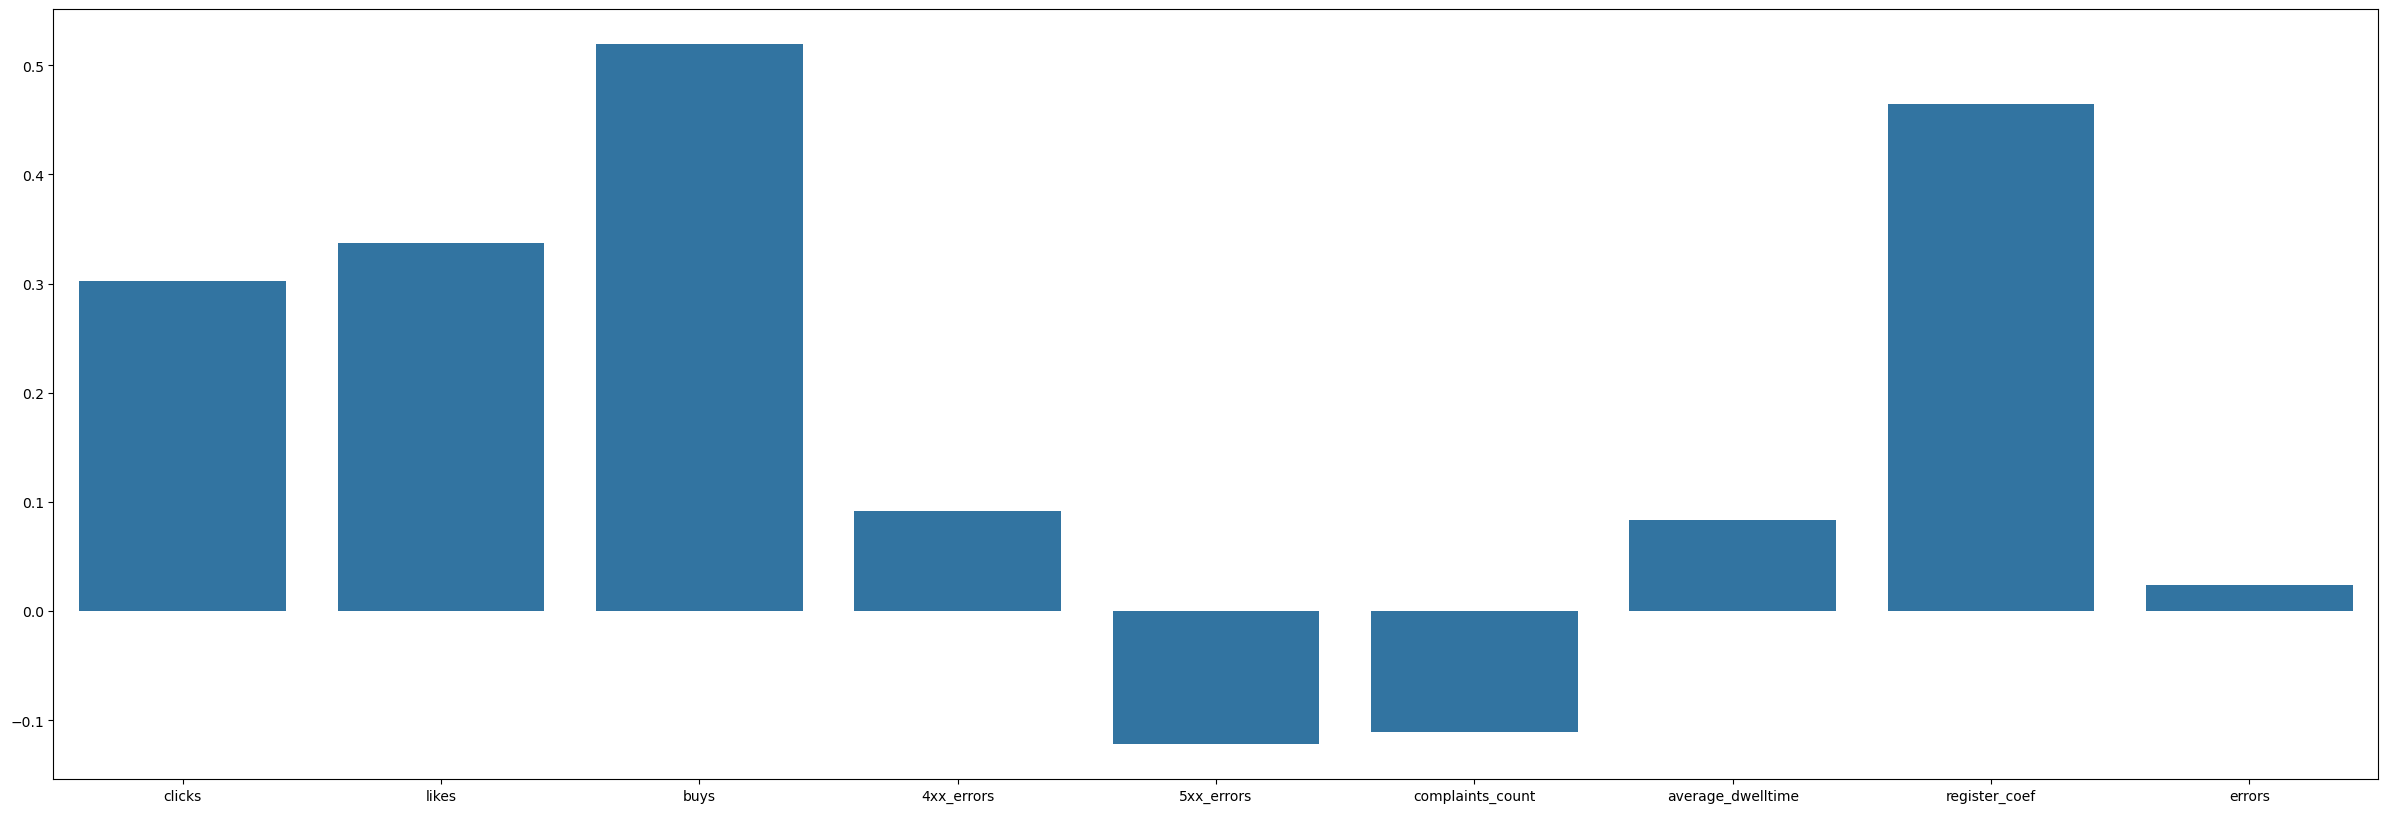

In [2841]:
correl = data_clean[numeric_features.columns].corrwith(Y)

plot = sns.barplot(correl)
plot.figure.set_size_inches(30,10)

In [2842]:
data_clean["buys^2"] = data_clean["buys"]*data_clean["buys"]
correl

clicks               0.302036
likes                0.337277
buys                 0.519362
4xx_errors           0.091700
5xx_errors          -0.121937
complaints_count    -0.110380
average_dwelltime    0.083157
register_coef        0.464758
errors               0.024084
dtype: float64

In [2843]:
data_clean["register_coef^2"] = data_clean["register_coef"]*data_clean["register_coef"]

In [2844]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)
model = LinearRegression()
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.010921
TRAIN MSE 0.011754
TEST MAE 0.104502


## Видим улучшение при добавление поленомов 

average_dwelltime
-1.0    321
Name: count, dtype: int64


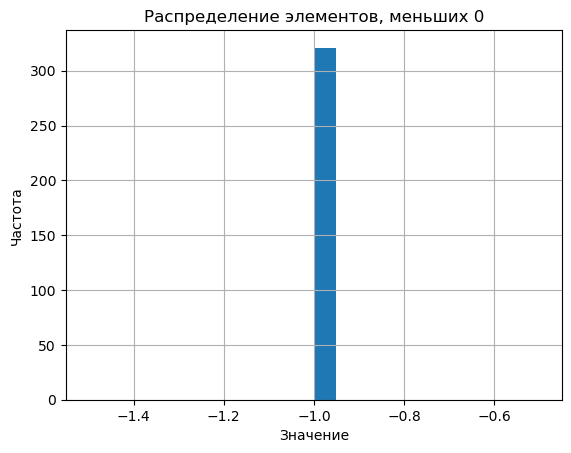

In [2846]:
negative_values = data_clean[data['average_dwelltime'] < 0]

negative_values_distribution = negative_values['average_dwelltime'].value_counts()

print(negative_values_distribution)

negative_values['average_dwelltime'].hist(bins=20)
plt.title('Распределение элементов, меньших 0')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()

In [2847]:
data_clean = data_clean[data["average_dwelltime"]>=0]

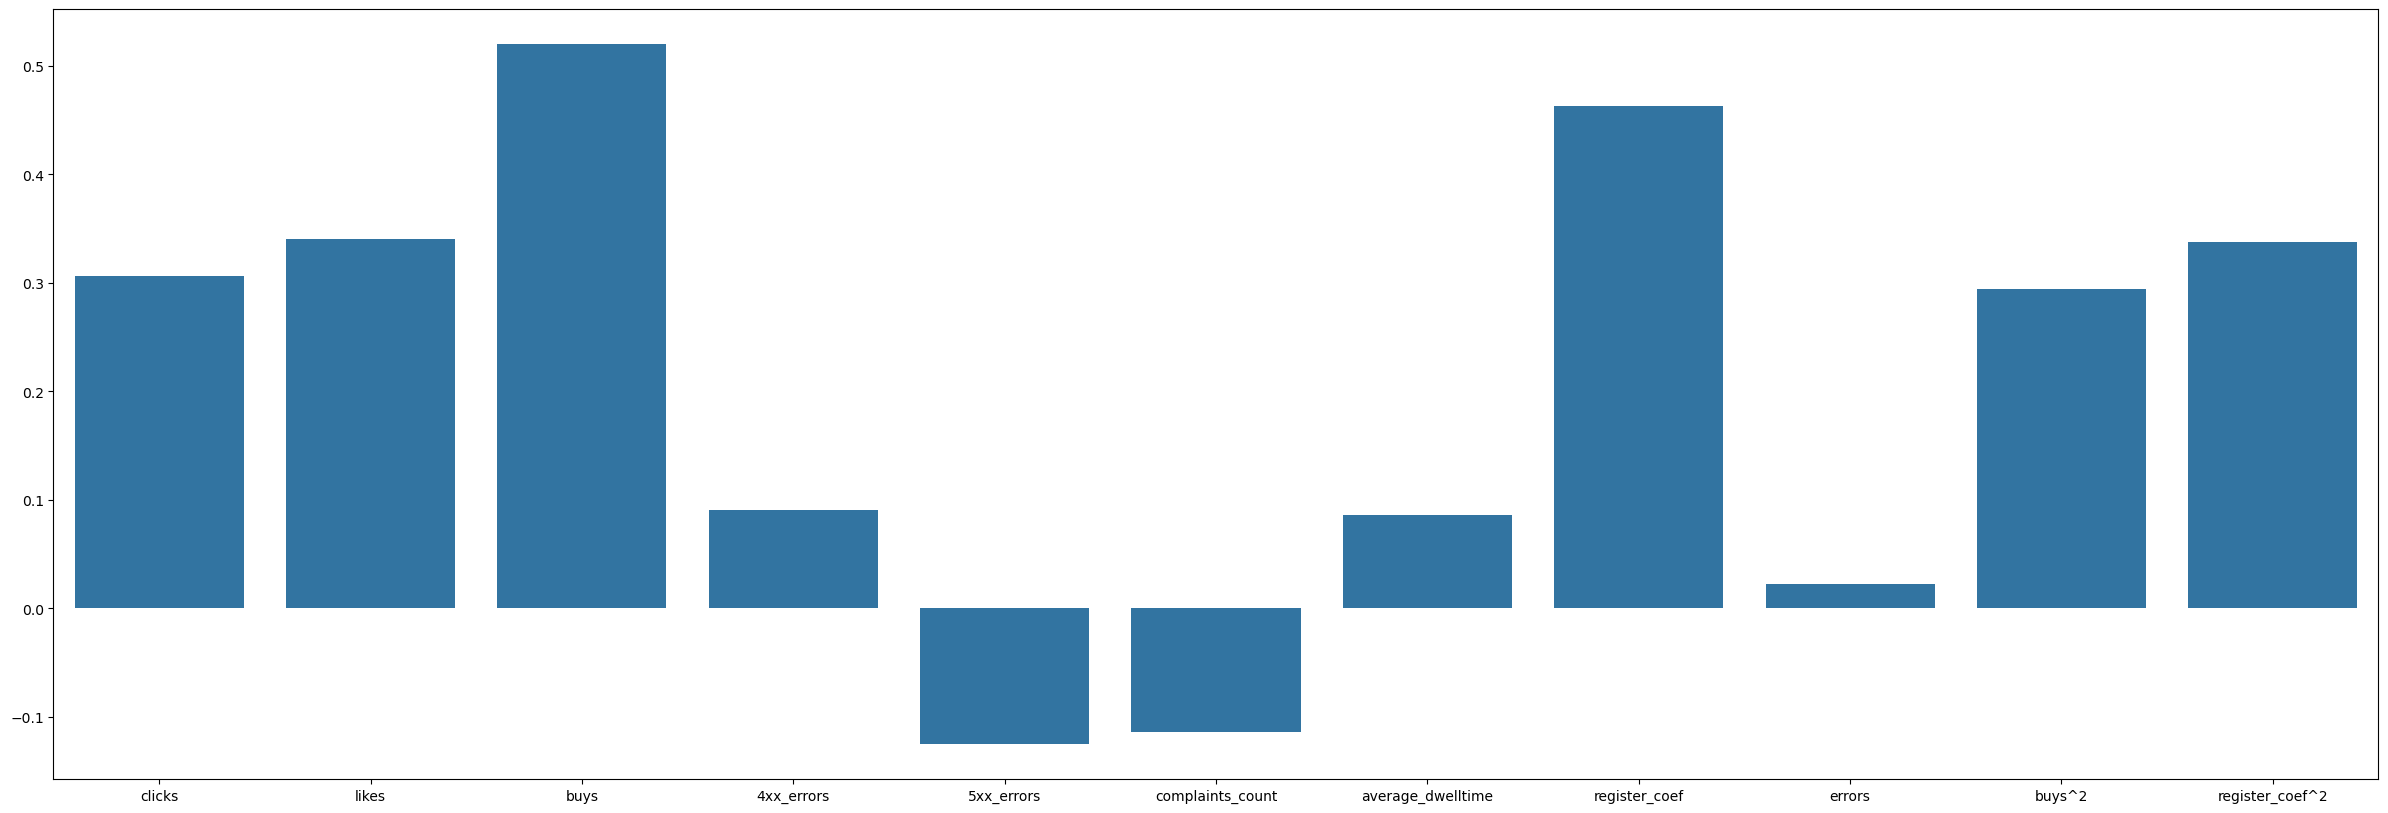

In [2848]:
numeric_features = data_clean.select_dtypes(np.number).drop(columns="source_attractiveness")
numeric_features
correl = data_clean[numeric_features.columns].corrwith(Y)

plot = sns.barplot(correl)
plot.figure.set_size_inches(30,10)

In [2849]:
correl

clicks               0.306483
likes                0.340580
buys                 0.520065
4xx_errors           0.090670
5xx_errors          -0.125219
complaints_count    -0.113697
average_dwelltime    0.086340
register_coef        0.462741
errors               0.022049
buys^2               0.294101
register_coef^2      0.337755
dtype: float64

In [2850]:
numeric_features_columns = numeric_features.columns
numeric_features_columns

Index(['clicks', 'likes', 'buys', '4xx_errors', '5xx_errors',
       'complaints_count', 'average_dwelltime', 'register_coef', 'errors',
       'buys^2', 'register_coef^2'],
      dtype='object')

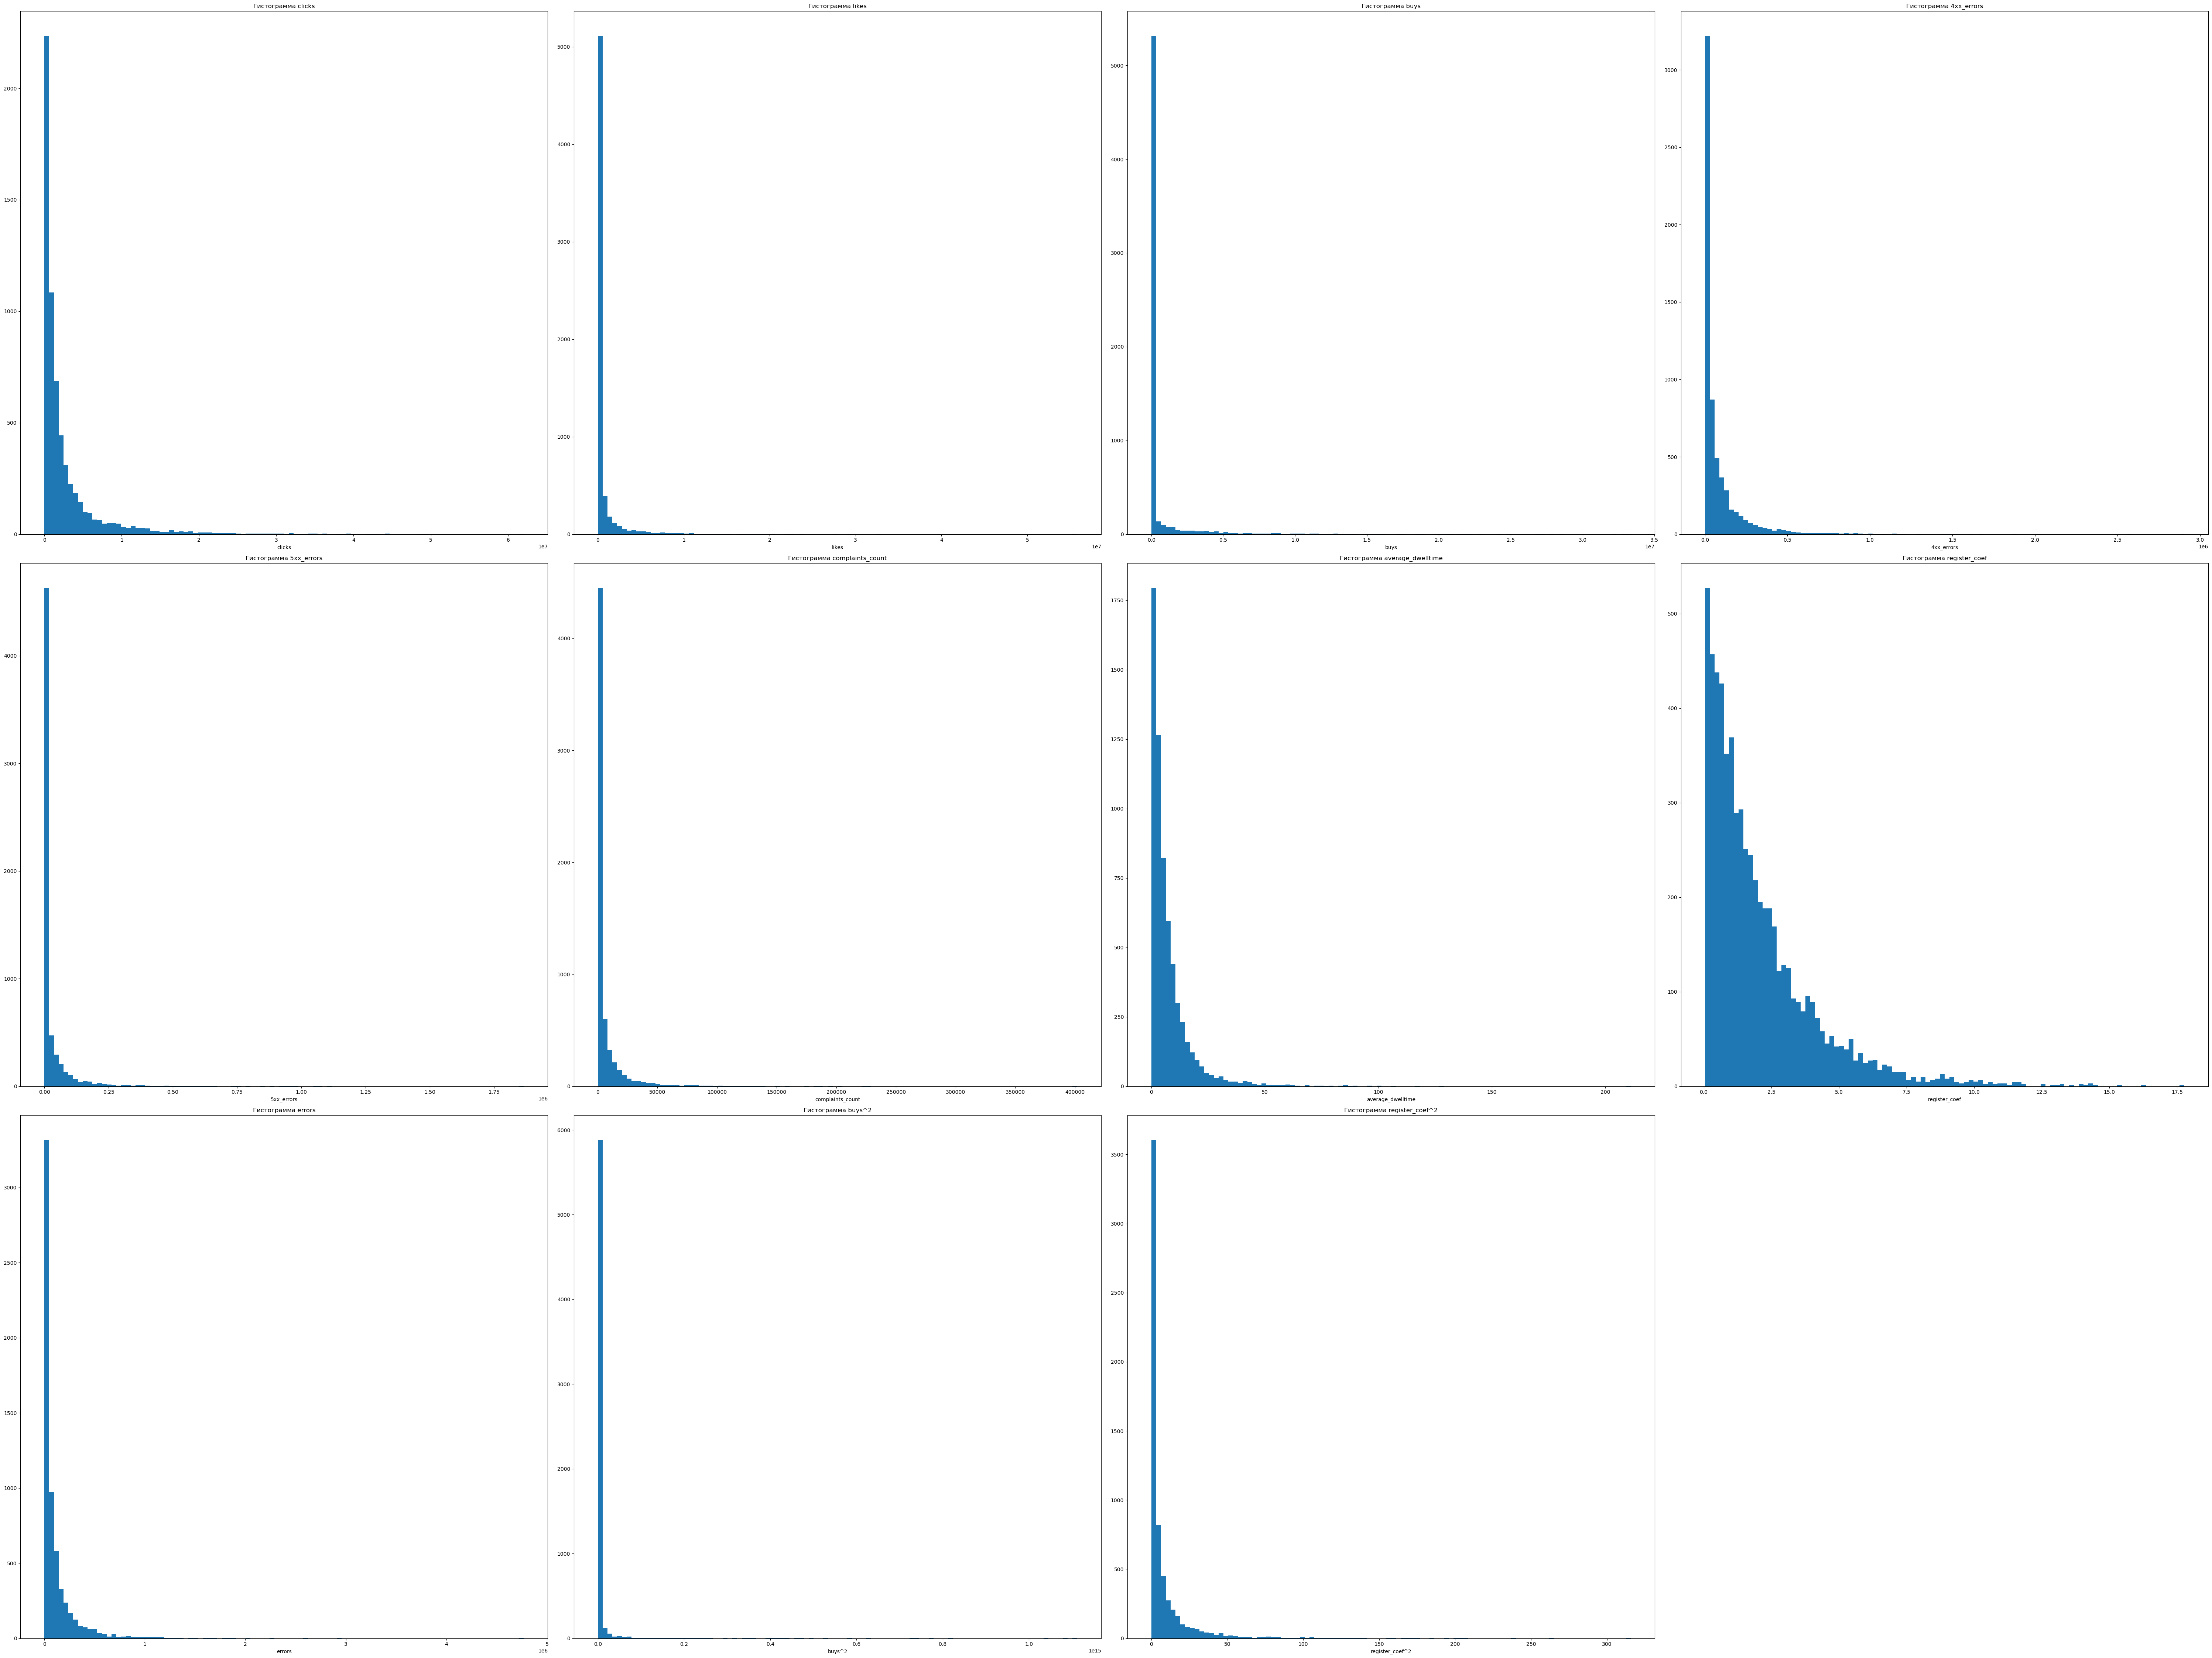

In [2851]:
fig, axs = plt.subplots(3,4,figsize=(60, 45))

axs = axs.flatten()


for i, feature in enumerate(numeric_features_columns):
    axs[i].hist(data_clean[feature],bins=100)
    axs[i].set_xlabel(feature)
    axs[i].set_title(f'Гистограмма {feature}')
    
for index in range(11, len(axs)):
    fig.delaxes(axs[index])

plt.tight_layout()
plt.show()

In [2852]:
data_clean['involvement'] = (data_clean["buys"]+data_clean["clicks"]+data_clean["likes"])/data_clean["average_dwelltime"]

In [2853]:
data_clean.sample(20)

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,register_coef,errors,buys^2,register_coef^2,involvement
3612,ecom,3600823.0,0.0,2862731,97728,14714,3749.0,2.002405,0.583093,0.816107,112442,8195228778361,0.666031,3.227896e+06
991,information_source,2106762.0,247126.0,0,205187,0,24.0,2.763090,0.064929,0.797218,205187,0,0.635557,8.519043e+05
4925,ecom,18418150.0,18418150.0,8781905,0,0,168.0,50.204152,0.848022,0.905859,0,77121855429025,0.820581,9.086540e+05
6026,ecom,2802776.0,0.0,473498,79347,0,1403.0,3.065656,0.297459,1.831885,79347,224200356004,3.355801,1.068703e+06
1651,social,641223.0,115345.0,0,0,0,708.0,9.430536,0.324666,4.183332,0,0,17.500270,8.022534e+04
7867,information_source,622982.0,215848.0,0,4469,0,234.0,1.033754,0.206545,1.172723,4469,0,1.375280,8.114406e+05
3685,information_source,70487.0,19914.0,0,473,0,0.0,0.258503,0.090758,0.543785,473,0,0.295702,3.497097e+05
6675,information_source,765815.0,0.0,0,57406,0,184.0,4.438704,0.291323,5.617161,57406,0,31.552496,1.725312e+05
5052,porn,30729.0,0.0,0,1644,4843,1768.0,19.012055,0.164227,4.754766,6487,0,22.607795,1.616290e+03
7870,information_source,206288.0,14334.0,0,3133,17017,3018.0,0.297170,0.222494,3.917431,20150,0,15.346264,7.424097e+05


<Axes: >

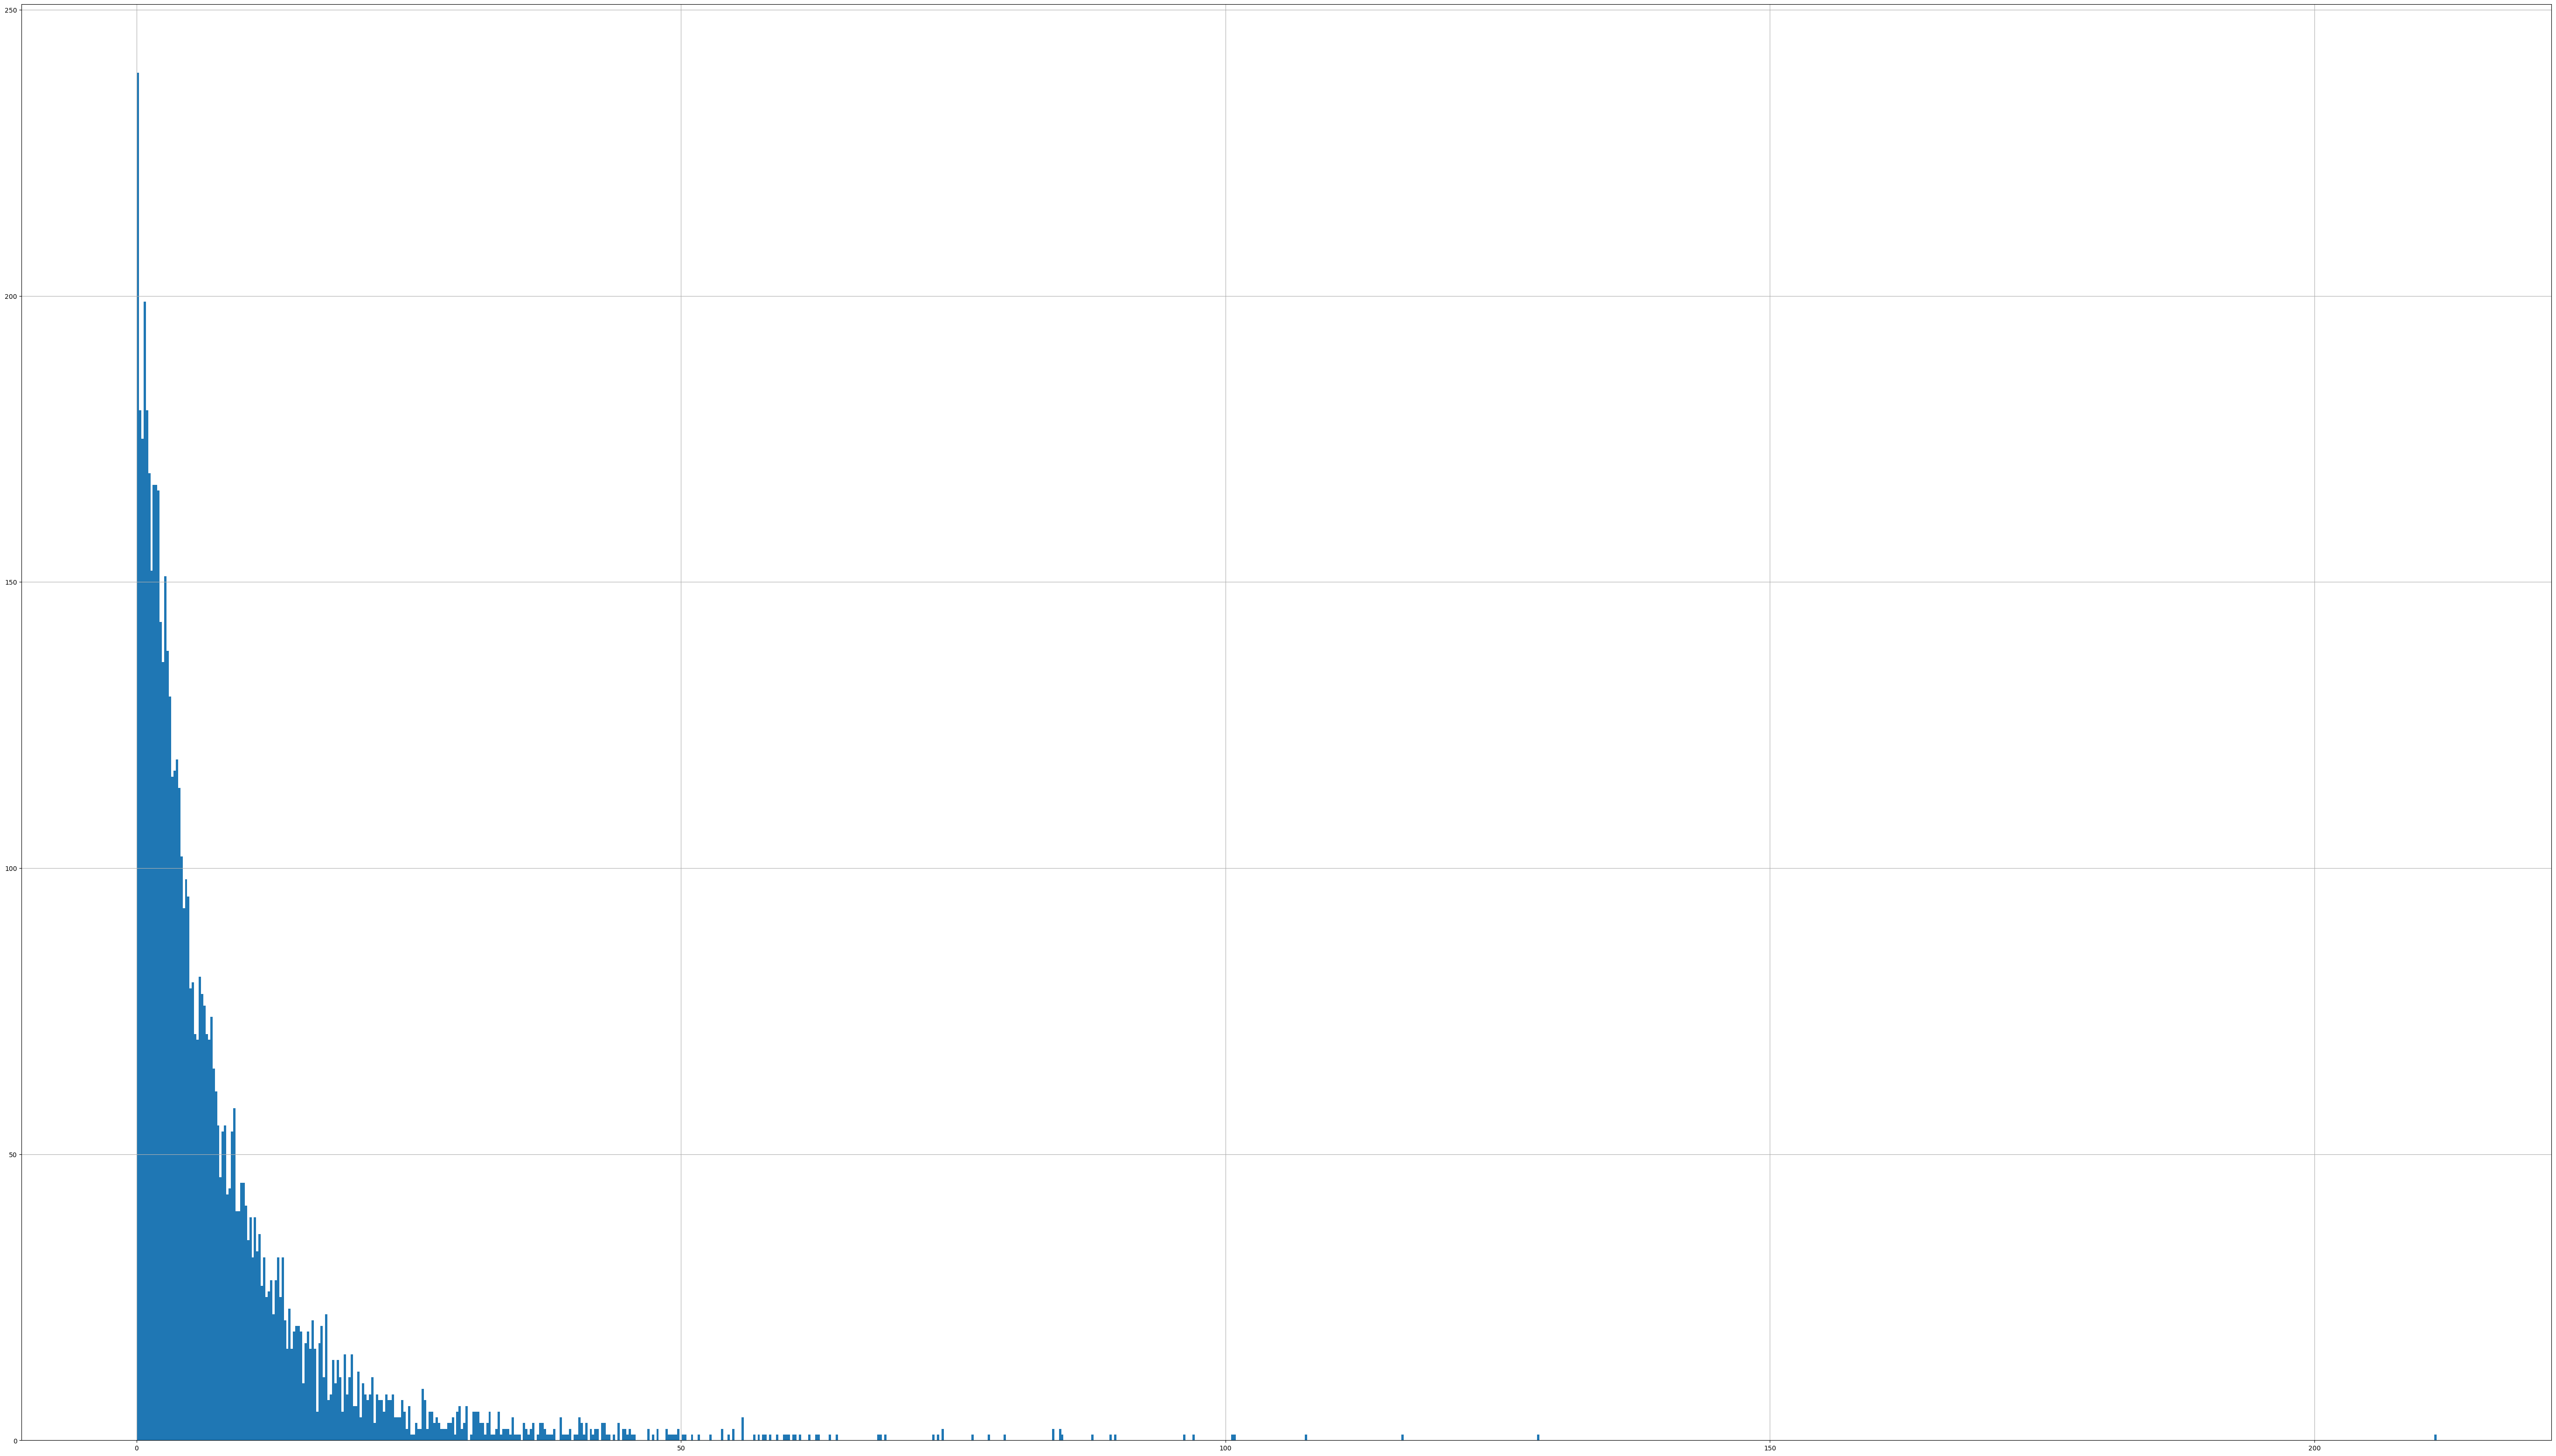

In [2854]:
data_clean["average_dwelltime"].hist(bins=1000,figsize=(70,40))

In [2855]:
counter = (data_clean["average_dwelltime"]<0.000000001).sum()
counter

0

### Тестовый раз с частично обработанными признаками с default regression

In [2857]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)
model = LinearRegression()
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.010415
TRAIN MSE 0.011712
TEST MAE 0.102052


### Eсть улучшение но не сильное 

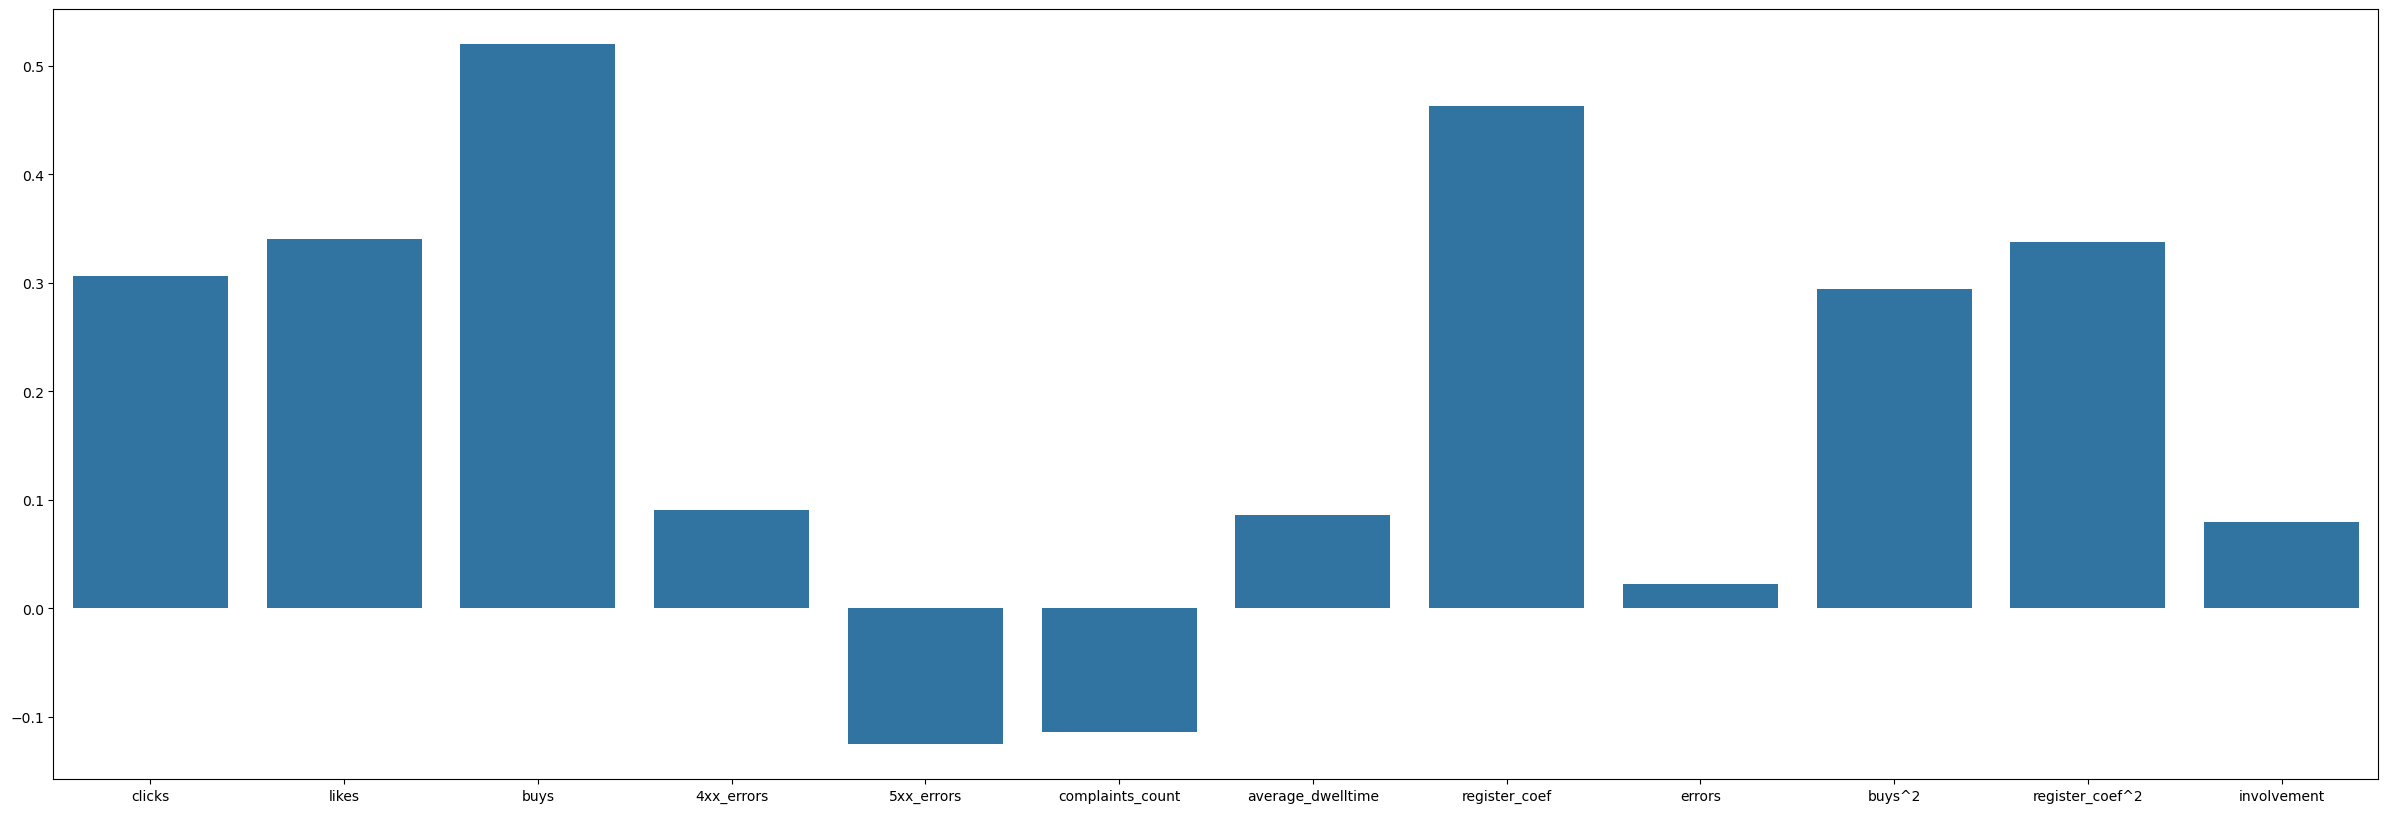

In [2859]:
numeric_features = data_clean.select_dtypes(np.number).drop(columns="source_attractiveness")
correl = data_clean[numeric_features.columns].corrwith(Y)

plot = sns.barplot(correl)
plot.figure.set_size_inches(30,10)

<Axes: >

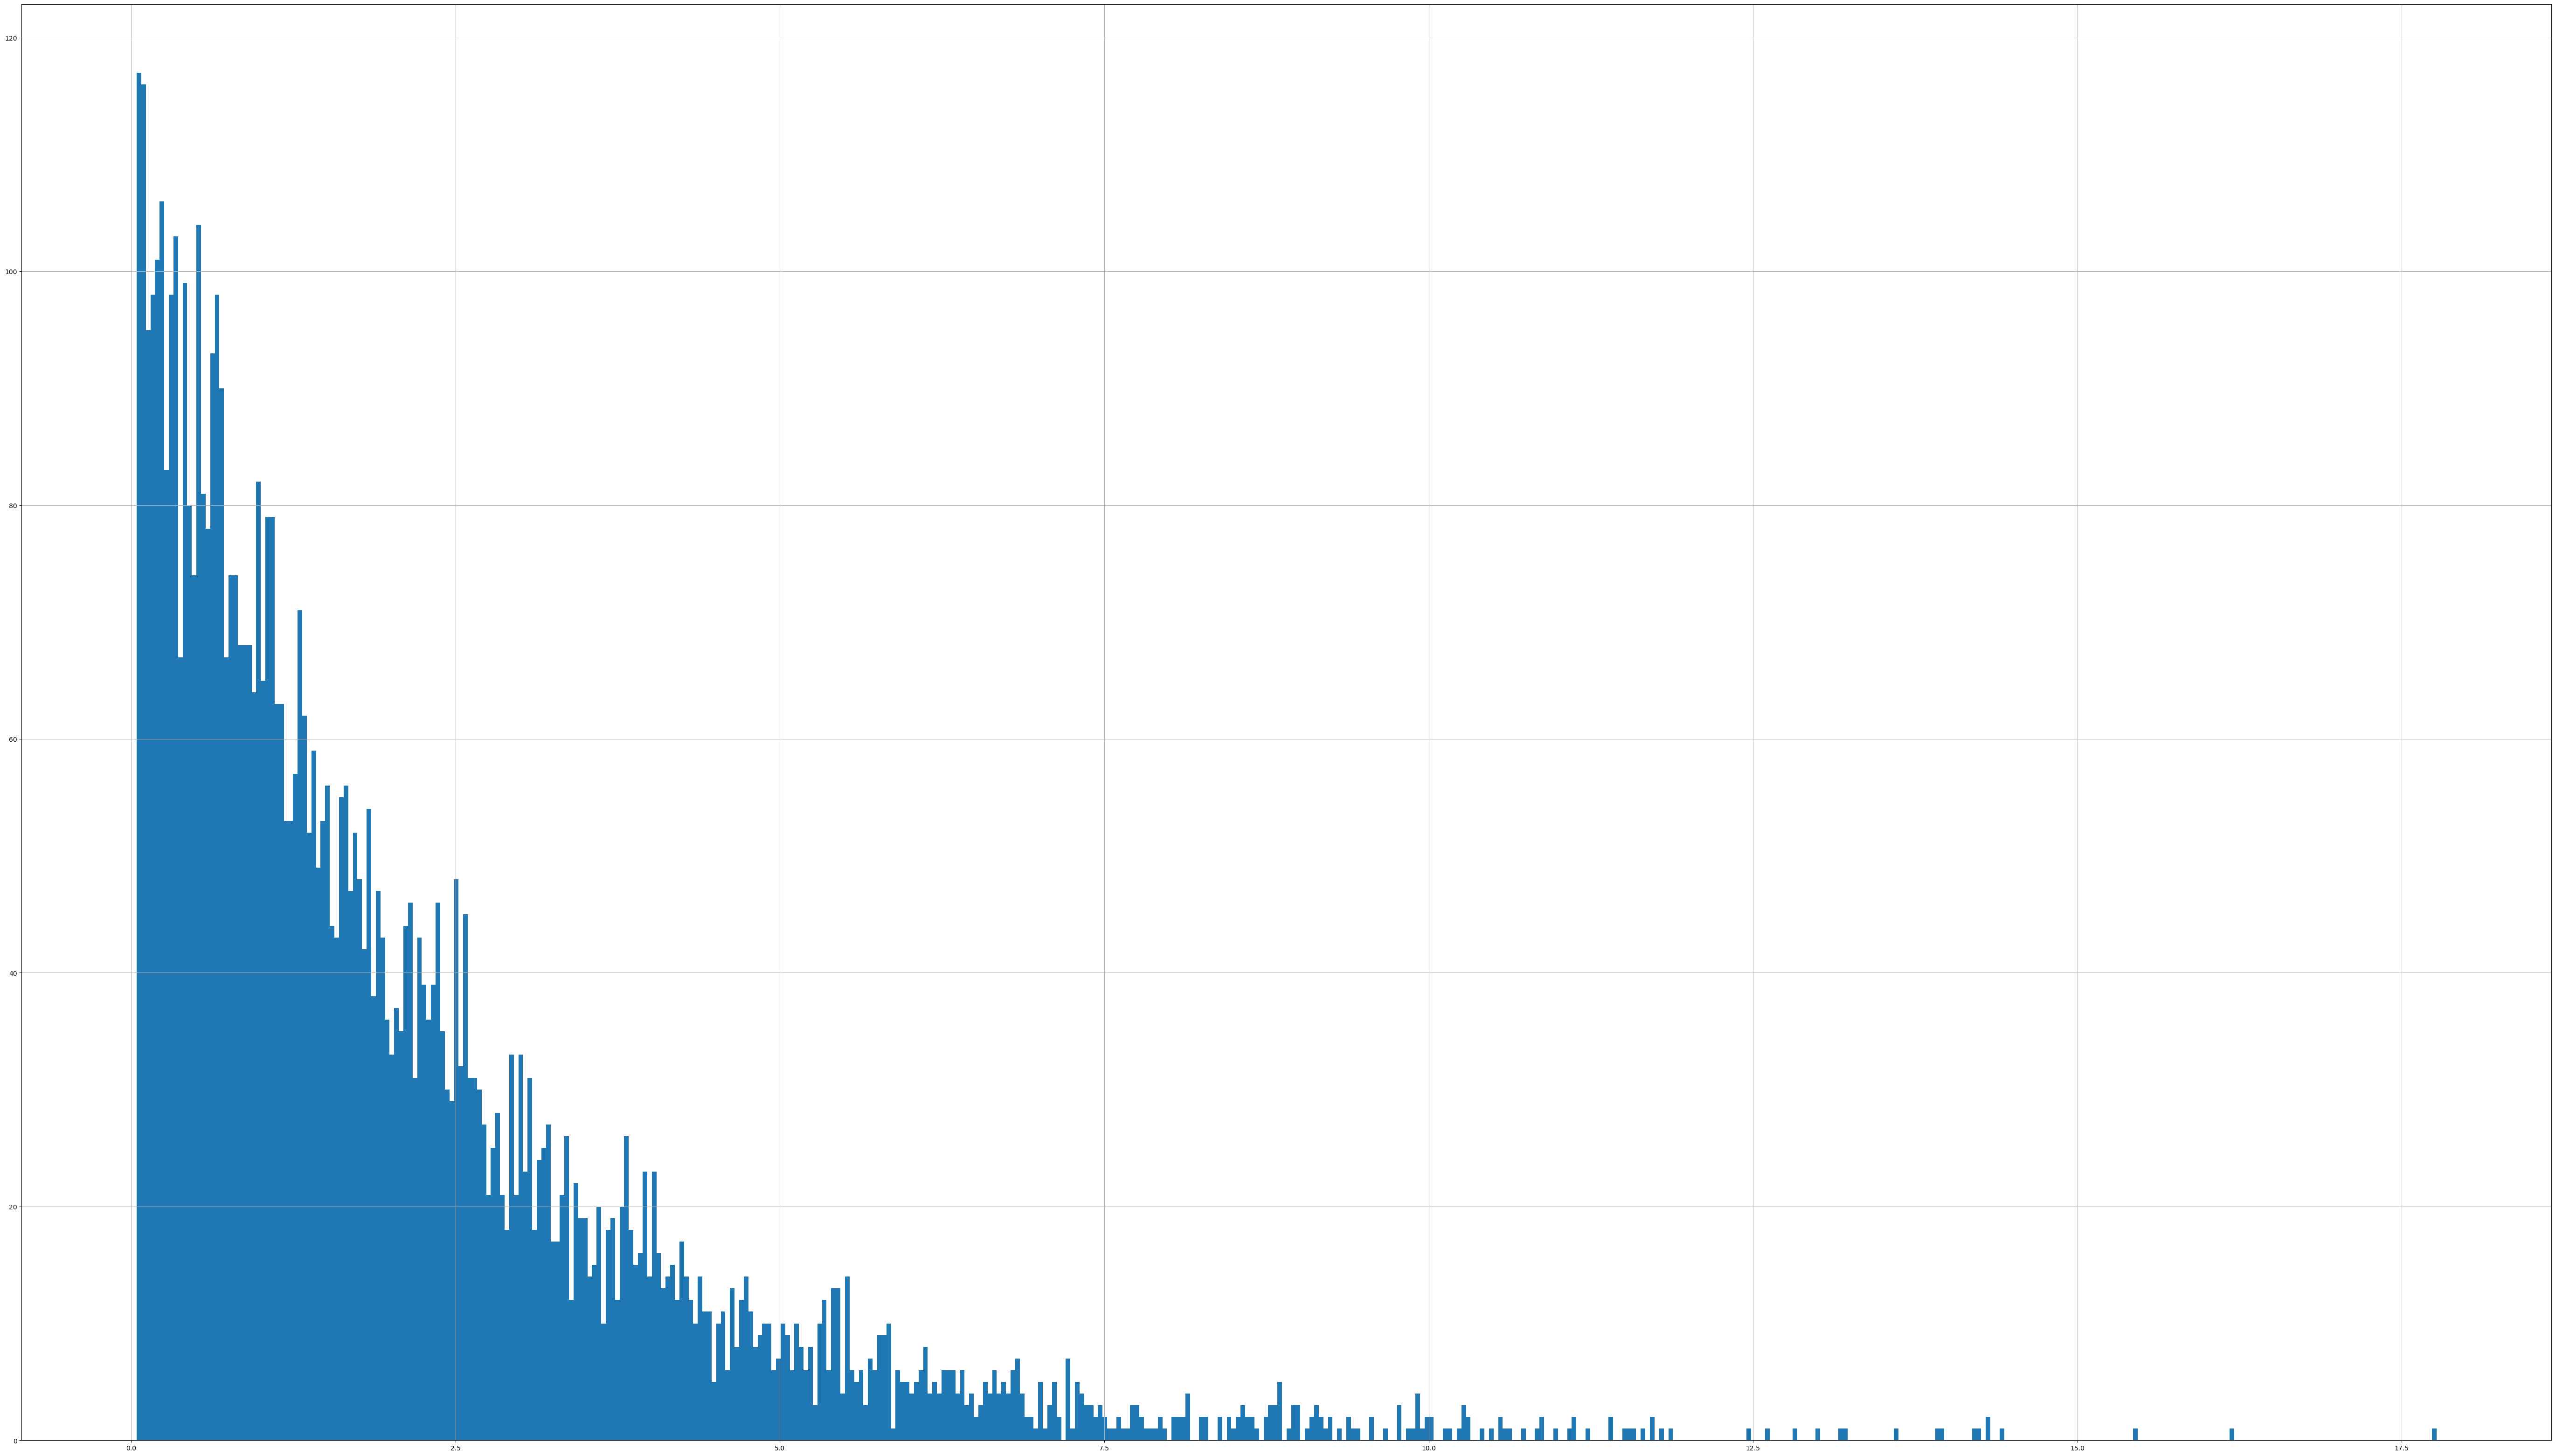

In [2860]:
data_clean["register_coef"].hist(bins=500,figsize=(70,40))

<Axes: >

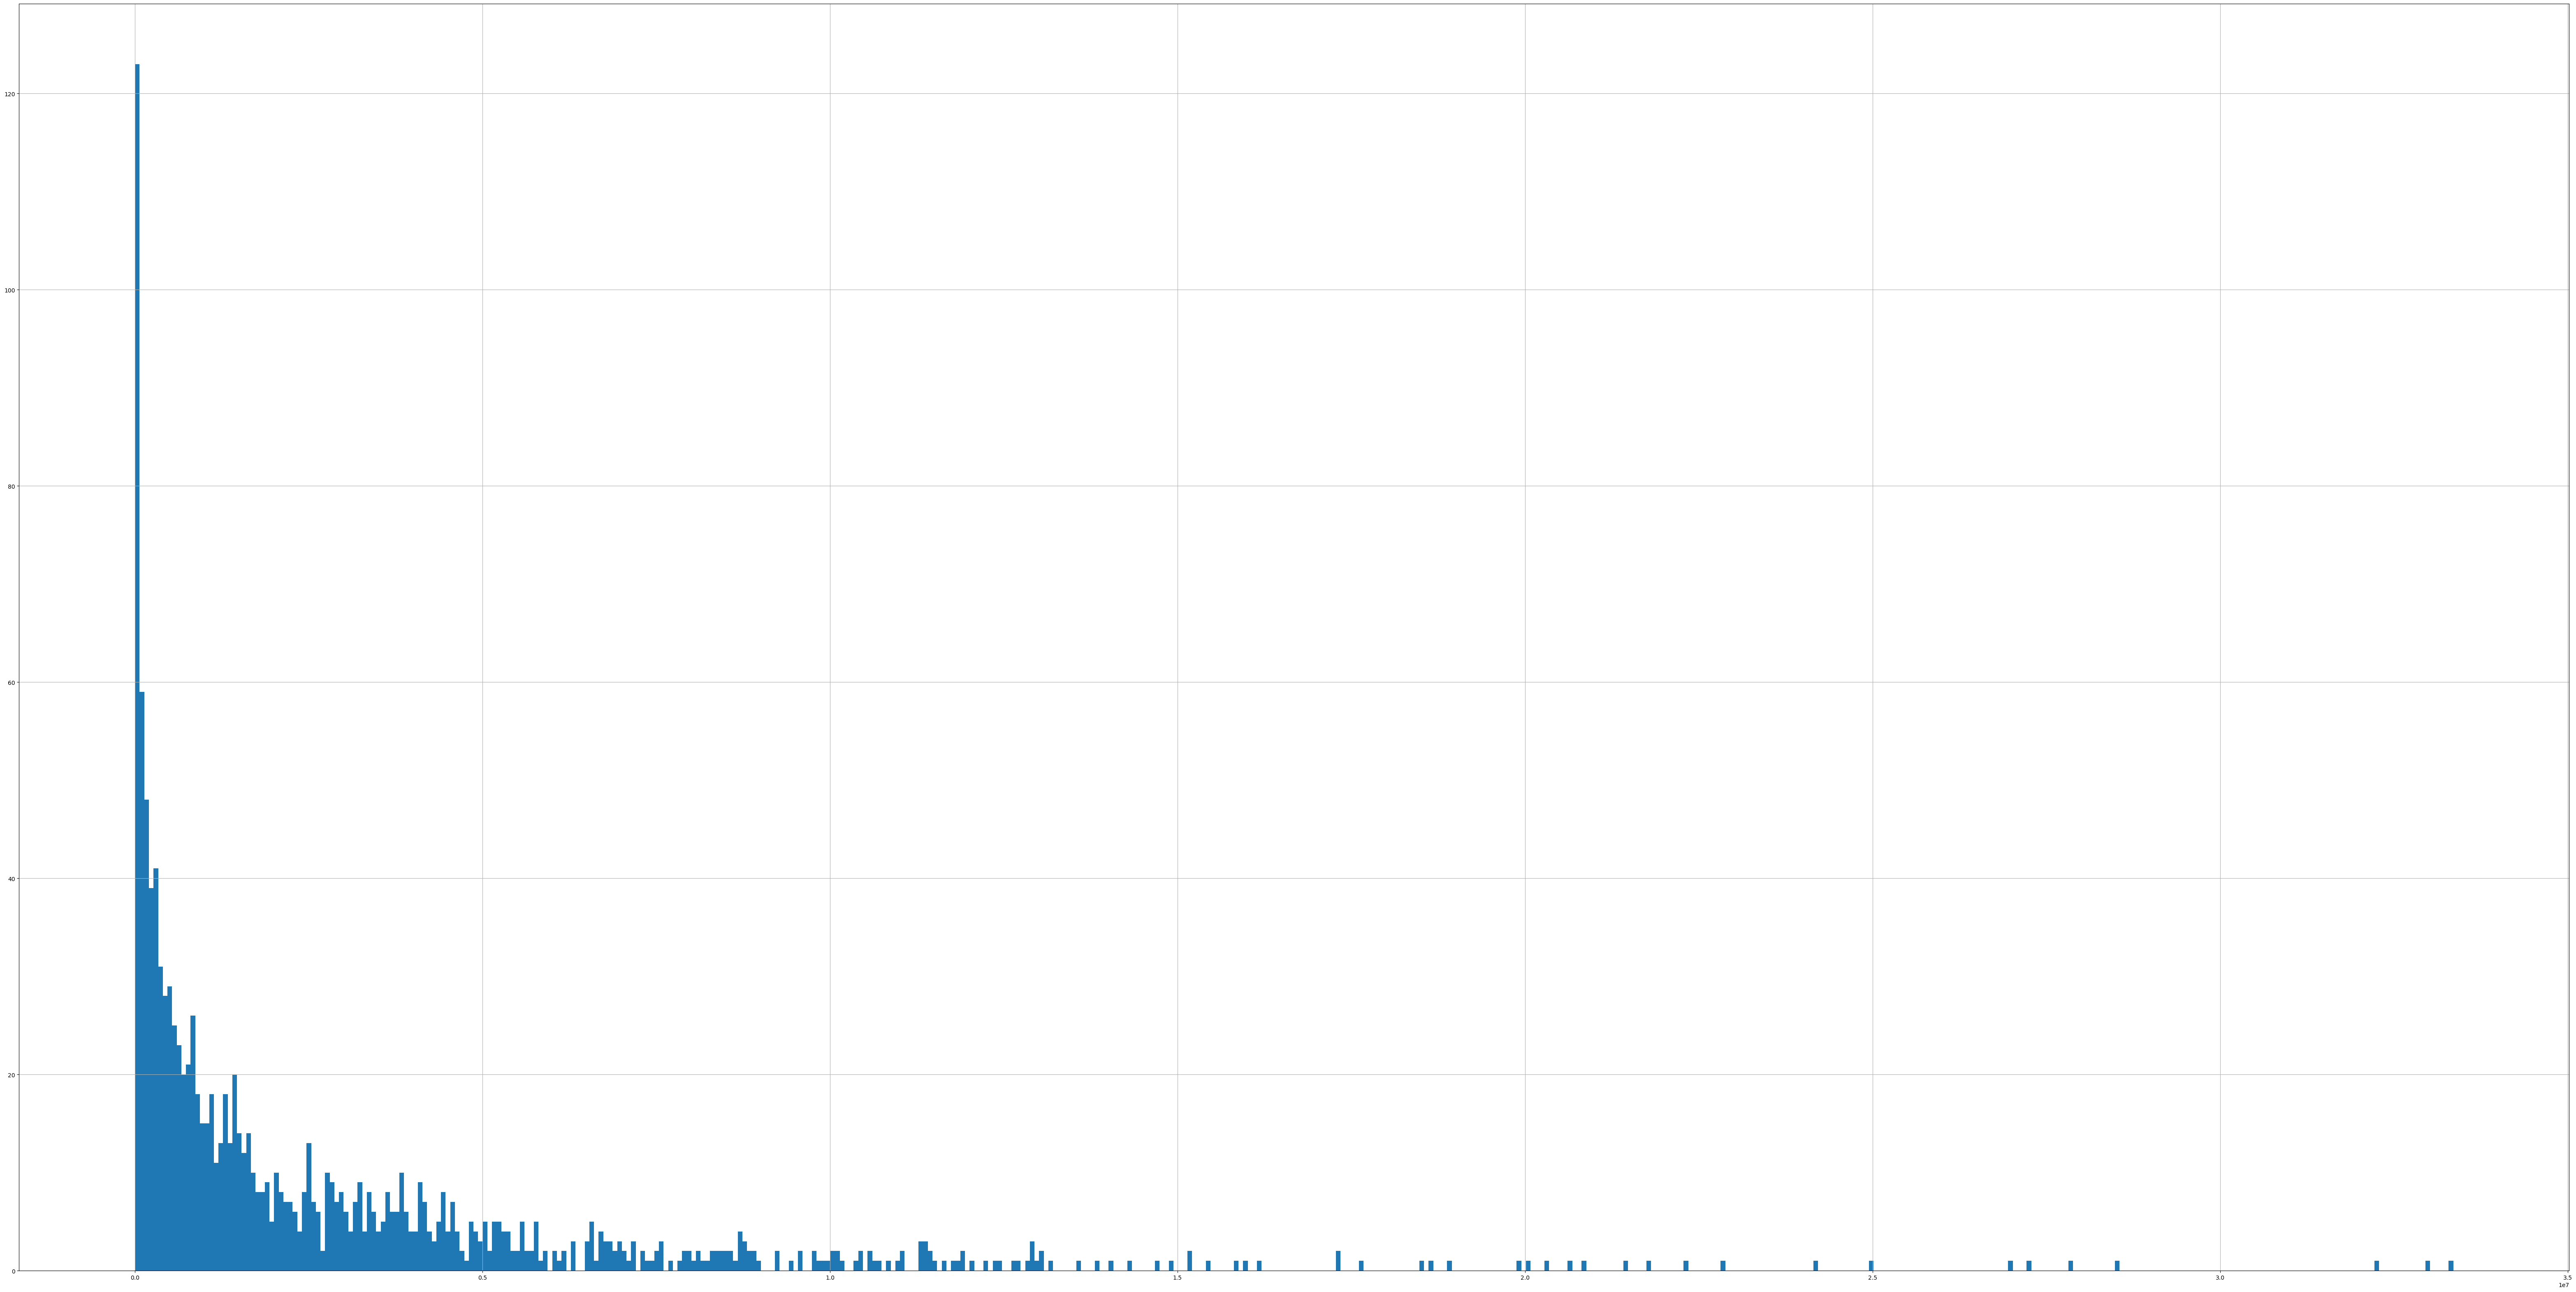

In [2861]:
buys_more_zero = data_clean[data_clean["buys"]>0]
buys_more_zero["buys"].hist(bins=500,figsize=(80,40))

In [2862]:
for i in numeric_features.columns:
    counter = (data_clean[i]<0).sum()
    print(f"{i}: counter - {counter}")

clicks: counter - 0
likes: counter - 0
buys: counter - 0
4xx_errors: counter - 0
5xx_errors: counter - 0
complaints_count: counter - 0
average_dwelltime: counter - 0
register_coef: counter - 0
errors: counter - 0
buys^2: counter - 0
register_coef^2: counter - 0
involvement: counter - 0


In [2863]:
counter_clicks = (data_clean["clicks"]>0).sum()
counter_likes =(data_clean["likes"]>0).sum()
print(f"counter_clicks {counter_clicks}")
print(f"counter_likes {counter_likes}")


counter_clicks 6229
counter_likes 4380


In [2864]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)
model = LinearRegression()
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.010415
TRAIN MSE 0.011712
TEST MAE 0.102052


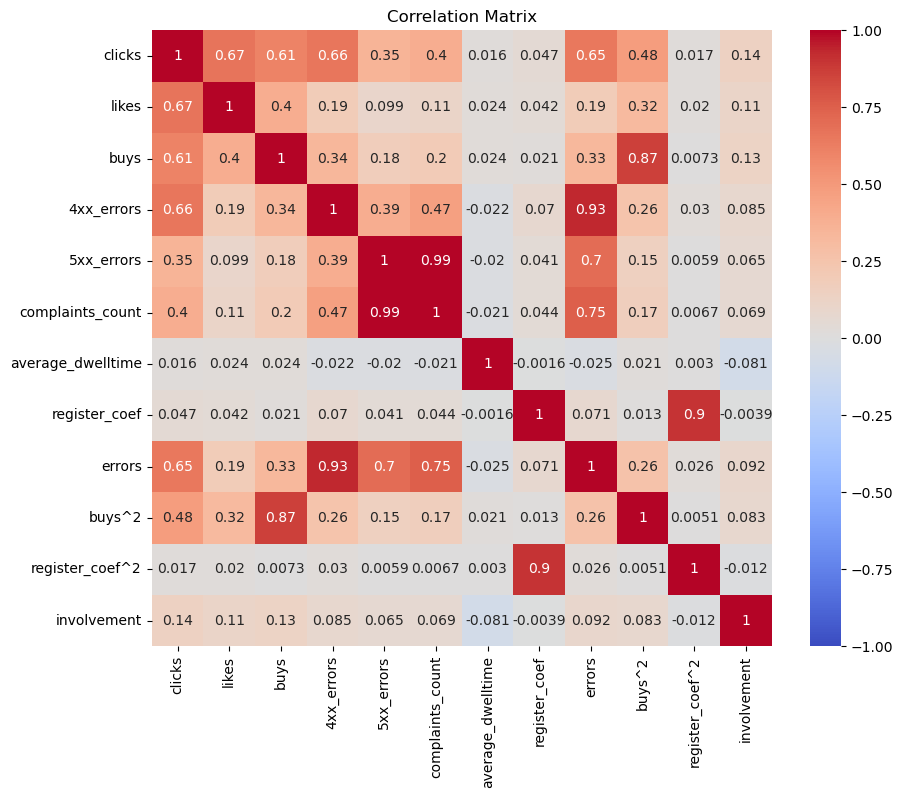

In [2865]:
numeric_columns = numeric_features.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [2866]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

model = LinearRegression()
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.010408
TRAIN MSE 0.011713
TEST MAE 0.102019


In [2867]:
model.coef_

array([-7.91823117e-02,  4.73759701e-02,  1.97775939e-01,  1.73388946e+10,
        8.30074721e+09, -6.67780207e-02,  2.22080186e-02,  2.01166224e-01,
       -2.20133704e+10, -9.61054832e-02, -1.03905491e-01,  1.29040856e-03,
       -4.88054140e+11, -5.31792130e+11, -3.24606069e+11, -2.21776168e+11,
       -2.29519342e+11])

<Axes: >

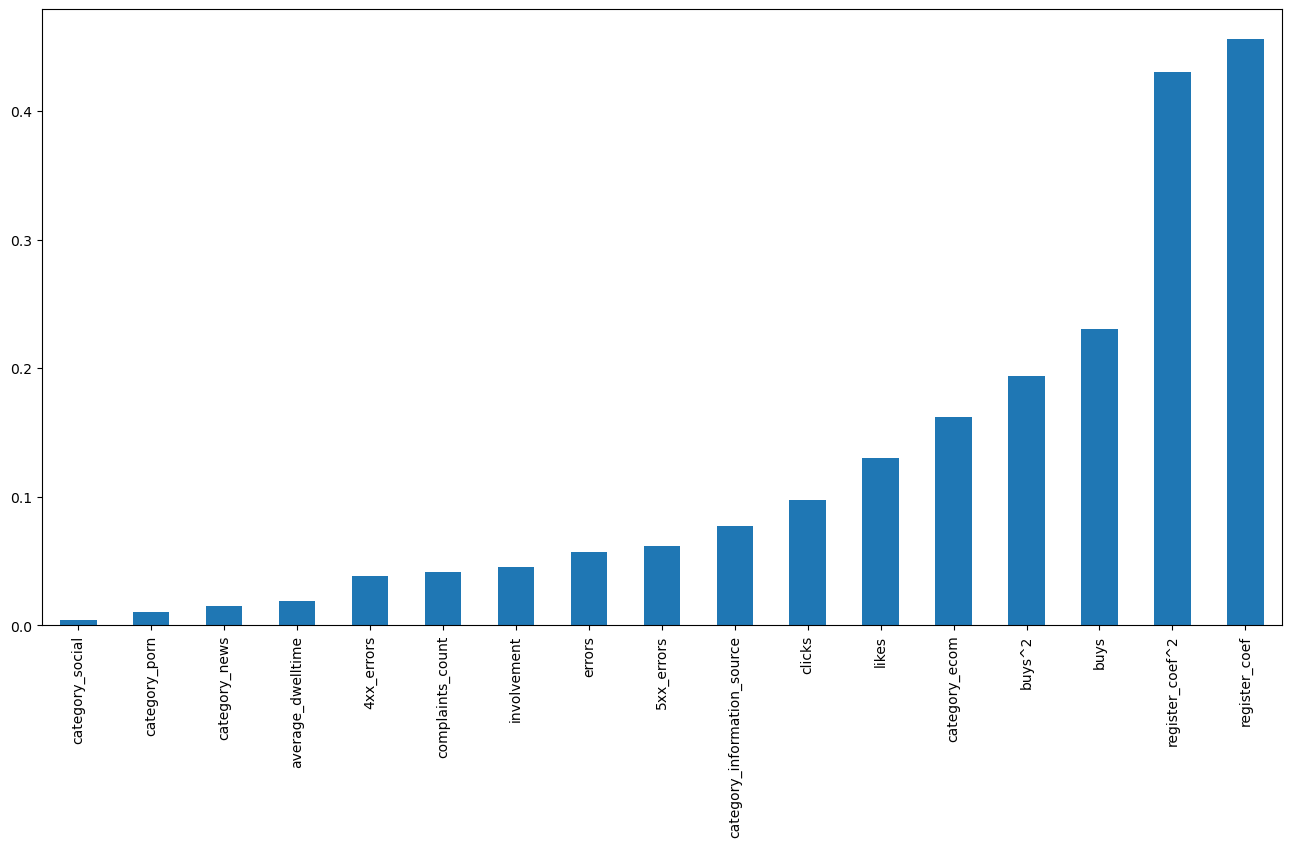

In [2868]:

mi = mutual_info_regression(X,Y)
mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values().plot.bar(figsize=(16,8))


In [2869]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

model = Lasso(alpha=0.000001)
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.010414
TRAIN MSE 0.011712
TEST MAE 0.102051


In [2870]:
model.coef_

array([-0.07882542,  0.04729242,  0.19813539, -0.00972882,  0.00955657,
       -0.06461577,  0.02215723,  0.20113739,  0.02975782, -0.09642971,
       -0.10390265,  0.00143125,  0.08801338,  0.01319794, -0.00048012,
       -0.01271325, -0.00728507])

In [2871]:
data_clean = data_clean.drop(columns="4xx_errors")

In [2872]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

model = Lasso(alpha=0.001)
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.010180
TRAIN MSE 0.011803
TEST MAE 0.100897


In [2873]:
model.coef_

array([-0.06526457,  0.04124093,  0.18811903, -0.0396268 , -0.00055439,
        0.02004125,  0.19094897,  0.        , -0.08918771, -0.09342344,
        0.00048084,  0.07548968,  0.        , -0.00678273, -0.016467  ,
       -0.01123911])

In [2874]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

model = Ridge(alpha=70)
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.010145
TRAIN MSE 0.011870
TEST MAE 0.100721


In [2875]:
data_clean_ohe

,clicks,likes,buys,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,register_coef,errors,buys^2,register_coef^2,involvement,category_ecom,category_information_source,category_news,category_porn,category_social
1,874840.0,21100.0,0,0,0.0,10.721619,-0.022317,0.238375,12872,0,0.056823,8.356388e+04,0,1,0,0,0
2,571210.0,94707.0,0,7420,0.0,1.922243,0.046396,0.255639,7420,0,0.065352,3.464271e+05,0,1,0,0,0
3,89534.0,924.0,0,0,0.0,2.149243,-0.093360,0.093438,834,0,0.008731,4.208830e+04,0,0,1,0,0
4,1043953.0,289288.0,0,20260,3948.0,3.764965,0.027303,0.387772,78635,0,0.150367,3.541177e+05,0,1,0,0,0
6,99712.0,0.0,0,15178,3725.0,20.786928,0.063572,1.473325,15178,0,2.170687,4.796861e+03,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,4221099.0,1204744.0,0,24270,8234.0,0.451923,0.115761,0.887457,360482,0,0.787579,1.200613e+07,0,1,0,0,0
7995,1468601.0,474524.0,0,83928,16841.0,4.191481,0.017470,1.321027,145235,0,1.745113,4.635892e+05,0,1,0,0,0
7996,93172.0,6418.0,0,705,0.0,3.745192,-0.019069,0.231877,4123,0,0.053767,2.659142e+04,0,1,0,0,0
7997,82916.0,0.0,0,1718,1007.0,5.837475,-0.061523,0.328112,6020,0,0.107658,1.420409e+04,0,1,0,0,0


In [2876]:
data_clean["likes^2"] = data_clean["likes"]*data_clean["likes"]

In [2877]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

model = Ridge(alpha=70)
model.fit(X_train,Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(X_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.009986
TRAIN MSE 0.011790
TEST MAE 0.099930


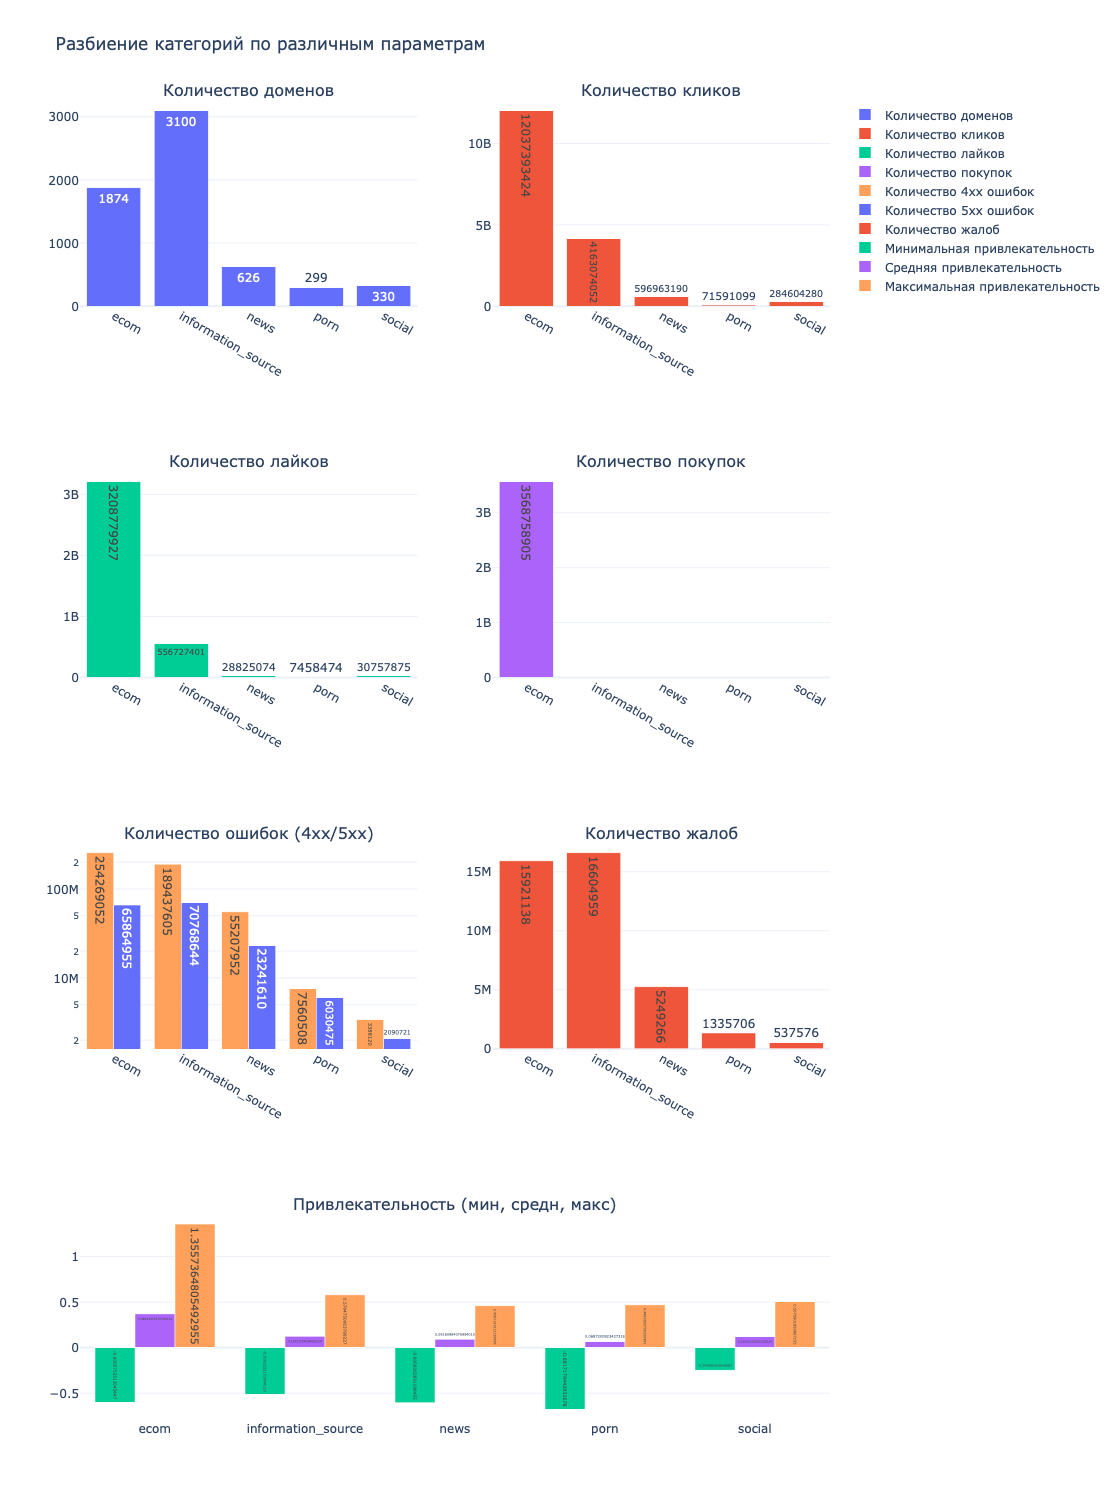

In [2878]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Создаём подграфики (subplots) для различных зависимостей
categories_bars = make_subplots(
    rows=4, cols=2,
    specs=[
        [{}, {}],
        [{}, {}],
        [{}, {}],
        [{"colspan": 2}, None],
    ],
    subplot_titles=[
        'Количество доменов',
        'Количество кликов',
        'Количество лайков',
        'Количество покупок',
        'Количество ошибок (4xx/5xx)',
        'Количество жалоб',
        'Привлекательность (мин, средн, макс)',
    ],
)

# Цветовая палитра
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

# 1. Количество доменов
categories_bars.add_trace(
    go.Bar(
        name='Количество доменов',
        x=categories_count.index,
        y=categories_count.values,
        marker_color=colors[0],
        text=categories_count.values,
        textposition='auto'
    ),
    row=1, col=1
)

# 2. Количество кликов
categories_bars.add_trace(
    go.Bar(
        name='Количество кликов',
        x=categories_clicks.index,
        y=categories_clicks.values,
        marker_color=colors[1],
        text=categories_clicks.values,
        textposition='auto'
    ),
    row=1, col=2
)

# 3. Количество лайков
categories_bars.add_trace(
    go.Bar(
        name='Количество лайков',
        x=categories_likes.index,
        y=categories_likes.values,
        marker_color=colors[2],
        text=categories_likes.values,
        textposition='auto'
    ),
    row=2, col=1
)

# 4. Количество покупок
categories_bars.add_trace(
    go.Bar(
        name='Количество покупок',
        x=categories_buys.index,
        y=categories_buys.values,
        marker_color=colors[3],
        text=categories_buys.values,
        textposition='auto'
    ),
    row=2, col=2
)

# 5. Ошибки 4xx и 5xx (один график для обоих)
categories_bars.add_trace(
    go.Bar(
        name='Количество 4xx ошибок',
        x=categories_4xx.index,
        y=categories_4xx.values,
        marker_color=colors[4],
        text=categories_4xx.values,
        textposition='auto'
    ),
    row=3, col=1
)

categories_bars.add_trace(
    go.Bar(
        name='Количество 5xx ошибок',
        x=categories_5xx.index,
        y=categories_5xx.values,
        marker_color=colors[0],
        text=categories_5xx.values,
        textposition='auto'
    ),
    row=3, col=1
)

# Логарифмическая шкала для ошибок
categories_bars.update_yaxes(type='log', row=3, col=1)

# 6. Количество жалоб
categories_bars.add_trace(
    go.Bar(
        name='Количество жалоб',
        x=categories_complaints.index,
        y=categories_complaints.values,
        marker_color=colors[1],
        text=categories_complaints.values,
        textposition='auto'
    ),
    row=3, col=2
)

# 7. Привлекательность (мин, средн, макс)
categories_bars.add_trace(
    go.Bar(
        name='Минимальная привлекательность',
        x=categories_attractiveness.min().index,
        y=categories_attractiveness.min().values,
        marker_color=colors[2],
        text=categories_attractiveness.min().values,
        textposition='auto'
    ),
    row=4, col=1
)

categories_bars.add_trace(
    go.Bar(
        name='Средняя привлекательность',
        x=categories_attractiveness.mean().index,
        y=categories_attractiveness.mean().values,
        marker_color=colors[3],
        text=categories_attractiveness.mean().values,
        textposition='auto'
    ),
    row=4, col=1
)

categories_bars.add_trace(
    go.Bar(
        name='Максимальная привлекательность',
        x=categories_attractiveness.max().index,
        y=categories_attractiveness.max().values,
        marker_color=colors[4],
        text=categories_attractiveness.max().values,
        textposition='auto'
    ),
    row=4, col=1
)

# Обновление оформления графиков
categories_bars.update_layout(
    title='Разбиение категорий по различным параметрам',
    barmode='group',
    width=1400, height=1500,  # Размеры графика
    showlegend=True,  # Легенда для графиков
    template='plotly_white',  # Стиль графиков
)

# Отображение графиков
categories_bars.show()

In [2879]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X_train)
X_interaction_test = poly.fit_transform(x_test)


model = Ridge(alpha=75)
model.fit(X_interaction,Y_train)
y_pred = model.predict(X_interaction_test)
y_train_pred = model.predict(X_interaction)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.006846
TRAIN MSE 0.007555
TEST MAE 0.082742


In [2880]:
data_clean = data_clean.drop(columns="5xx_errors")

In [2881]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X_train)
X_interaction_test = poly.fit_transform(x_test)


model = Ridge(alpha=42)
model.fit(X_interaction,Y_train)
y_pred = model.predict(X_interaction_test)
y_train_pred = model.predict(X_interaction)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.006732
TRAIN MSE 0.007207
TEST MAE 0.082051


In [2882]:
X_interaction.shape

(4983, 136)

In [2883]:
model.coef_


array([-2.12175484e-02,  1.12031549e-01,  7.60427763e-02, -5.45786210e-02,
        3.27479228e-02,  2.09070500e-01, -2.22587994e-02, -3.50089829e-02,
       -1.39585682e-01,  1.30795091e-03, -1.95942289e-02,  3.25047774e-02,
       -2.14158246e-02, -4.46269031e-03, -4.38181315e-03, -8.95317193e-03,
       -1.14644235e-03, -5.58058034e-02,  4.24928133e-03, -1.14193621e-02,
       -1.93245147e-02,  1.43532263e-02,  4.48061768e-02,  1.52895951e-02,
        1.06627061e-03,  2.54120431e-02, -3.48848794e-02,  4.61638201e-03,
        1.93138419e-02,  3.04045379e-02,  6.78967623e-03, -1.77000999e-02,
        7.25693964e-03,  3.76009639e-03, -1.63441822e-02, -2.70781333e-03,
        4.12317507e-03,  1.43561644e-02, -9.32971372e-04, -7.03372004e-03,
       -3.64852494e-03,  2.02013521e-02, -2.23330674e-02, -1.25998341e-02,
        4.71223800e-03,  3.30192104e-03,  2.92071028e-03, -9.22171904e-03,
        5.31948243e-04, -2.89390158e-03,  5.07165012e-03, -6.83024391e-03,
        2.57223263e-02,  

In [2884]:
data_ecom = data_clean[data_clean["category"]=="ecom"]
data_ecom

,category,clicks,likes,buys,complaints_count,average_dwelltime,source_attractiveness,register_coef,errors,buys^2,register_coef^2,involvement,likes^2
7,ecom,31677060.0,8760379.0,0,8519.0,8.066347,0.080541,0.653280,924098,0,0.426774,5.013104e+06,7.674424e+13
9,ecom,1695855.0,0.0,1601683,1171.0,9.834370,0.757402,1.265828,78271,2565388432489,1.602320,3.353075e+05,0.000000e+00
10,ecom,1726730.0,1022561.0,548138,3668.0,5.436714,0.476799,1.321715,33013,300455267044,1.746932,6.065114e+05,1.045631e+12
15,ecom,328718.0,169297.0,127781,0.0,4.260996,0.644069,4.228497,8086,16327983961,17.880189,1.468661e+05,2.866147e+10
16,ecom,105646.0,0.0,9828,0.0,5.236229,-0.006107,0.245772,825,96589584,0.060404,2.205290e+04,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7967,ecom,4194366.0,0.0,3453568,16859.0,11.398056,0.606864,0.825309,188304,11927131930624,0.681134,6.709858e+05,0.000000e+00
7971,ecom,8640022.0,471732.0,0,1267.0,11.005891,0.173117,2.000046,127622,0,4.000186,8.278979e+05,2.225311e+11
7977,ecom,5042924.0,1274898.0,5042924,28645.0,1.525583,0.904862,2.636767,308385,25431082469776,6.952539,7.446824e+06,1.625365e+12
7987,ecom,9206957.0,0.0,4496093,11756.0,1.872118,0.501125,2.198716,491477,20214852264649,4.834351,7.319545e+06,0.000000e+00


In [2885]:
data_clean['buy_per_clicks'] = data_clean['buys'] / data_clean['clicks']
data_clean['likes_per_cliks'] = data_clean['likes'] / data_clean['clicks']
data_clean["buys_per_reg_coef"] = data_clean["clicks"]/ data_clean["register_coef"]
#data_clean["clicks_per_avg_dwelltime"] = data_clean["clicks"]/ data_clean["average_dwelltime"]

In [2886]:
data_clean_ohe = pd.get_dummies(data_clean, columns=['category'], dtype=np.int16)

Y = data_clean_ohe["source_attractiveness"]
X = data_clean_ohe.drop(columns="source_attractiveness")


X_train, x_test, Y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interaction_train = poly.fit_transform(X_train)
x_interaction_test = poly.fit_transform(x_test)


model = Ridge(alpha=42)
model.fit(X_interaction_train,Y_train)
y_pred = model.predict(x_interaction_test)
y_train_pred = model.predict(X_interaction_train)

print("TEST MSE %.6f"%metrics.mean_squared_error(y_pred,y_test))
print("TRAIN MSE %.6f"%metrics.mean_squared_error(y_train_pred,Y_train))
print("TEST MAE %.6f"%metrics.mean_squared_error(y_pred,y_test,squared=False))

TEST MSE 0.001494
TRAIN MSE 0.001433
TEST MAE 0.038648


### BEST = 0.001378

In [3]:
#df.fillna(df.mean(), inplace=True)

NameError: name 'df' is not defined